In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

### DATA LOADING

In [2]:
df = pd.read_csv("youtube_ad_revenue_dataset.csv")

print("\n--- Data Head ---")
print(df.head())

print("\n--- Data Info ---")
df.info()

# Check missing values percentage
print("\n--- Missing Values (% of total) ---")
print((df.isnull().sum() / len(df) * 100).round(2))


--- Data Head ---
   video_id                        date  views   likes  comments  \
0  vid_3092  2024-09-24 10:50:40.993199   9936  1221.0     320.0   
1  vid_3459  2024-09-22 10:50:40.993199  10017   642.0     346.0   
2  vid_4784  2024-11-21 10:50:40.993199  10097  1979.0     187.0   
3  vid_4078  2025-01-28 10:50:40.993199  10034  1191.0     242.0   
4  vid_3522  2025-04-28 10:50:40.993199   9889  1858.0     477.0   

   watch_time_minutes  video_length_minutes  subscribers       category  \
0        26497.214184              2.862137       228086  Entertainment   
1        15209.747445             23.738069       736015         Gaming   
2        57332.658498             26.200634       240534      Education   
3        31334.517771             11.770340       434482  Entertainment   
4        15665.666434              6.635854        42030      Education   

   device country  ad_revenue_usd  
0      TV      IN      203.178237  
1  Tablet      CA      140.880508  
2      TV    

### FEATURE ENGINEERING

In [3]:
# Fill missing likes/comments with 0
df['likes'] = df['likes'].fillna(0)
df['comments'] = df['comments'].fillna(0)

# Create Engagement Rate
df['engagement_rate'] = (df['likes'] + df['comments']) / df['views'].replace(0, np.nan)
df['engagement_rate'] = df['engagement_rate'].fillna(0)

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Create time-based features
df['upload_month'] = df['date'].dt.month
df['upload_dayofweek'] = df['date'].dt.dayofweek

In [ ]:
# Features and targets

target = 'ad_revenue_usd'

# Drop non-predictive columns
df = df.drop(columns=['video_id', 'date'], errors='ignore')

# Separate features and target
X = df.drop(columns=[target], errors='ignore')
y = df[target]

In [5]:
# Numerical and Categorical features

numerical_features = [
    'views', 'likes', 'comments',
    'watch_time_minutes', 'video_length_minutes',
    'subscribers', 'engagement_rate'
]

categorical_features = [
    'category', 'device', 'country',
    'upload_month', 'upload_dayofweek'
]

# Handle missing features gracefully
numerical_features = [f for f in numerical_features if f in X.columns]
categorical_features = [f for f in categorical_features if f in X.columns]

### MODEL BUILDING

In [6]:
# Create Preprocessing pipelines

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

In [7]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\n✅ Data split complete: {X_train.shape[0]} train rows, {X_test.shape[0]} test rows")


✅ Data split complete: 97920 train rows, 24480 test rows


In [8]:
# Models

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
}

In [9]:
# Training and Evaluating

results = {}

for name, model in models.items():
    print(f"\n Training {name} ...")
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Train model
    full_pipeline.fit(X_train, y_train)

    # Predict on test data
    y_pred = full_pipeline.predict(X_test)

    # Evaluate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results[name] = {'R2': r2, 'RMSE': rmse, 'MAE': mae, 'Model': full_pipeline}

    print(f" {name}: R²={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}")


🚀 Training Linear Regression ...
✅ Linear Regression: R²=0.945, RMSE=14.543, MAE=4.970

🚀 Training Ridge Regression ...
✅ Ridge Regression: R²=0.945, RMSE=14.543, MAE=4.970

🚀 Training Lasso Regression ...
✅ Lasso Regression: R²=0.944, RMSE=14.635, MAE=5.678

🚀 Training Decision Tree Regressor ...
✅ Decision Tree Regressor: R²=0.901, RMSE=19.485, MAE=5.216

🚀 Training Random Forest Regressor ...
✅ Random Forest Regressor: R²=0.947, RMSE=14.272, MAE=3.708


In [10]:
# Compare Models

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='R2', ascending=False)
print("\n--- Model Evaluation Results ---")
print(results_df[['R2', 'RMSE', 'MAE']])


--- Model Evaluation Results ---
                               R2       RMSE       MAE
Random Forest Regressor  0.946877  14.272172  3.707666
Ridge Regression         0.944843  14.542911  4.969791
Linear Regression        0.944843  14.542936  4.969838
Lasso Regression         0.944144  14.634796   5.67777
Decision Tree Regressor  0.900988  19.484694  5.216157


In [11]:
# Save the best model

best_model_name = results_df.index[0]
best_pipeline = results[best_model_name]['Model']

joblib.dump(best_pipeline, 'best_model.joblib')
print(f"\n Best model: {best_model_name}")
print(" Saved as: best_model.joblib")


 Best model: Random Forest Regressor
 Saved as: best_model.joblib


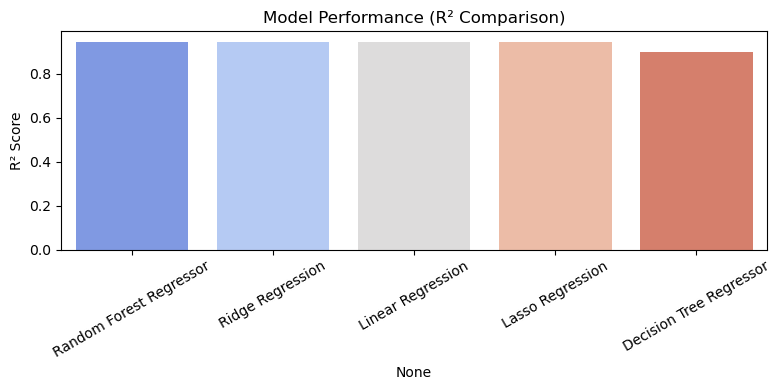

In [12]:
# Visualization

plt.figure(figsize=(8, 4))
sns.barplot(x=results_df.index, y='R2', data=results_df, palette='coolwarm')
plt.title('Model Performance (R² Comparison)')
plt.ylabel('R² Score')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()